# Restricted Boltzmann Machines

So far we have explored the flexibility of deep neural networks for performing *supervised learning*[.](./sgd.ipynb) After many of the deep-learning methods developed in the last few years have become widespread in the industrial practice, an increasing proportion of academics are now in the process of pushing forward the frontiers of *unsupervised learning*. 

[Recall](./velkomstdrink.ipynb) that behind unsupervised training stands the idea of recognizing arbitrary structures in the data. In particular, the problem of **generative modeling** concerns the task of drawing unseen samples from the data distribution.

The very recently developed **Variational Autoencoders** or **Generative Adversarial Networks** have brought spectacular advances. However, we begin by studying the  **Restricted Boltzmann Machines (RBM)**, which have already been proposed by [Smolensky](https://scholar.colorado.edu/cgi/viewcontent.cgi?article=1314&context=csci_techreports) in 1986. They have a solid theoretical foundation and are still useful for studying small-scale generative problems.

The idea behind RBMs is that the distribution of the data can be encoded by a typically small number of *latent factors*.

In this notebook, we follow the presentation in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html) and [Chapters 16, 17 and 18 in *Deep Learning*](http://www.deeplearningbook.org/).

## Definition

First, we give a rigorous mathematical definition of RBMs in the framework of energy-based models. Due to the specific choice of the energy function, RBMs are also amenable to an interpretation as graphical models on a bipartite network consisting of hidden and visible units. Finally, we discuss the computation of conditional probabilities, which will crucial to perform Gibbs sampling in the training phase.

### Energy-based Model

Let $I$ and $J$ be finite sets representing the *visible* and *hidden* units. Moreover, let $w_{ij} \in \mathbb{R}$ denote a weight representing the interaction strength between a visible unit $i \in V$ and a hidden unit $j \in H$. Given the weights, we associate to each binary configuration $(v, h) = (\{v_i\}_i, \{h_j\}_j) \in \{0, 1\}^I \times \{0, 1\}^J$ the **energy**
$$E(v,h) = -v^\top W h = -\sum_{i,j}v_i w_{ij}  h_j$$

Then, the associated **RBM** is the probability distribution on $\{0,1\}^I \times \{0,1\}^J$ whose density $p(v,h)$ is proportional to $\exp(-E(v,h))$. In other words,
$$p(v,h) = \frac{\exp(-E(v,h))}Z$$
where the normalization constant 
$$Z = \sum_{v, h} \exp(-v^\top W h)$$
is called the **partition function**.

### Graphical Model

Since the energy function $E$ contains only interaction terms between hidden units on the one hand and visible units on the other hand, we can also interpret as a graphical model on a *bipartite network*.

<img src="images/bipartite.png" alt="Drawing" style="width: 500px;"/>
http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html

Having a bipartite graph simply means that if we condition the hidden units, then the visible units are independent and conversely if we condition on the visible units and consider the hidden ones. This is summarized in the following Theorem.

**Theorem**

The visible units $V=\{V_i\}_i$ are conditionally independent given the hidden units $H=\{H_j\}_j$. More precisely,
$$\mathbb{P}(V_i=1|H=h) = \sigma\big(\sum_j w_{ij}h_j\big).$$
By symmetry, the same holds true when we interchange the rôles of $v$ and $h$.

**Proof**: **Homework** !

## Code Example

From the [sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html), we can take the following code example on how to fit an RBM to data. Here, we have 3 visible and 2 hidden units. The weights after the fit can be accessed via `model.components_`. We explore the mathematical background of this fitting procedure in the next section.

In [13]:
import numpy as np
from numpy import random
from sklearn.neural_network import BernoulliRBM
random.seed(42)

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = BernoulliRBM(n_components=2)
model.fit(X)
model.components_
??model

## Training

The training of RBMs is performed within the *MLE-framework*. This leads to a non-trivial statistical inference task, since only visible, but not the hidden units are observed. Hence, we are facing a latent-variable problem.

A first approach to this statistical inference problem would be invoking the *EM-algorithm*-- in particular, as the conditional distribution of the hidden units given the visible ones is analytically tractable.

However, the joint log-likelihood of hidden and observed variables still involves the intractable partition function $Z$. Hence, we need to resort to a suitable form of Gibbs sampling. Following the presentation by [Tielemann](http://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf), we present **contrastive divergence (CD)** and **persistent contrastive divergence (PCD)** as two possible sampling schemes that both come with their own pros & cons.

### MLE

In order to perform MLE, given data $v^{(1)}, \ldots, v^{(N)}$ we seek to choose the weights $W$ such that the log-likelihood
\begin{align*}
\sum_k \log (p_W(v^{(k)})) &= \sum_k \log\big(\sum_h \exp(-E_W(v^{(k)}, h))\big)  - N \log Z_W \\
&=: \phi^+_W - \phi^-_W
\end{align*}
where we have added the subscript $W$ to make the dependence on the weights more visible. Clearly, analytic optimization is not feasible. As in a [previous notebook](./sgd.ipynb), the first step is therefore to compute the derivative with respect to the weights.

Computing the gradient for the first expression  is straightforward (**Details: Homework!**)

$$\frac\partial{\partial w_{ij}}\phi^+_W = \sum_k v_i^{(k)} \mathbb{P}(h_j=1|V=v^{(k)}).$$
We have seen above, that the conditional probability can be computed explicitly.



On the other hand, computing the gradient with respect to the second expression  gives that (**Details: Homework!**)

$$\frac\partial{\partial w_{ij}}\phi^-_W = N  \mathbb{P}(v_i=1, h_j=1),$$
for which there is no closed-form expression. We estimate these probabilities using two specific Gibbs samplers described in more detail below: **Contrastive Divergence (CD)** and **Persistent Contrastive Divergence (PCD)**.



Once the Gibbs samplers are set up, the estimates for the weights $W$ are determined via gradient descent.

**Algorithm**
1. **Positive Phase.** Sample a mini-batch $\{v^{(i_1)}, \ldots, v^{(i_B)}\}$ from the data and compute the gradient $\nabla \phi^+_W$ as explained above with the sum only ranging over elements of the mini-batch. Update the weights according to $W + \alpha \nabla \phi^+_W$.
2.  **Negative Phase.** Compute the gradient $\nabla \phi^-_W$ either via CD or PCD and update the weights according to $W - \alpha \nabla \phi^-_W$.
3. Iterate until convergence



The positive and negative phase serve different purposes.

In the *positive phase*, we start from points sampled from the data distribution $p_{\mathsf{data}}$. We then change the weights $W$ in such a way that the likelihood under the model $p_{\mathsf{model}}$ of the points sampled from the data distribution increases.

In the *negative phase*, we start instead from points sampled from the model distribution $p_{\mathsf{model}}$. We then change the weights $W$ in such a way that the likelihood under the model $p_{\mathsf{model}}$ of the points sampled from the model distribution decreases.

The following comparison taken from Figure 18.1 in [*Deep Learning*](http://www.deeplearningbook.org/contents/partition.html) illustrates the two phases.
<img src="images/wakeSleep.png" alt="Drawing" style="width: 700px;"/>


### Block Gibbs Sampler

We begin by discussing the computation of the gradient $\phi^-_W$ in the negative phase. Remember that the gradient is composed of probabilities of the form $\mathbb{P}(v_i=1, h_j=1)$. Since we already have derived expressions for the conditional probabilities given the observed or hidden units, it is natural to approach this problem by using a block Gibbs sampler:

1. Initialize $x^{(1)} = (v^{(1)}, h^{(1)}), \ldots, x^{(m)} = (v^{(m)}, h^{(m)})$.
2. Update $x^{(i)}$ via $k\ge1$ Gibbs-sampling steps 
3. Compute the MC estimate $\tfrac1m \sum_i \nabla \hat{\phi}_W^-( x^{(i)})$ based on those updated values

The issue with this approach is that the second step can become prohibitively expensive if the initial values $x^{(i)}$ fall in highly unprobable regions of the model distribution, so that $k\ge1$ needs to be large to move beyond the burn-in. Therefore, a clever initialization strategy is critical.

### Contrastive Divergence

In the **Contrastive Divergence** method proposed by [Hinton and Salakhutdinov](http://science.sciencemag.org/content/313/5786/504), the $x^{(i)}$ are sampled from the data distribution. Although initially these samples are still far away from the stationary distribution, already the positive phase helps to push the model distribution closer to the data distribution. This speeds up the mixing in the Gibbs steps. Still, it remains the problem of rarely visiting states that are likely under the model, but unlikely under the data distribution.



### Persistent Contrastive Divergence

In the **Persistent Contrastive Divergence** method proposed by [Younes](https://www.tandfonline.com/doi/abs/10.1080/17442509908834179) and [Thielemann](http://icml2008.cs.helsinki.fi/papers/638.pdf), the $x^{(i)}$ are initialized with the last states of the previous gradient steps. In other words, the Gibbs sampler is not newly initialized after a gradient step, but keeps running.

Persistent contrastive divergence has good mixing properties, although issues can occur when the updates in the model distribution through the gradient steps are much faster than the mixing time.

**Homework.** Implement the Block Gibbs Sampler together with contrastive divergence and persistent contrastive divergence.

## Example

Here, we follow the [sklearn documentation](http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html) to see how RBMs can be used as feature extractors.  The example we consider here is the MNIST dataset. First, we load the data.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics

# Load Data
digits = datasets.load_digits()

Next, we perform a data augmentation step, by shifting the images slightly

In [15]:
def augment_data(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

#augment and normalize data
X = np.asarray(digits.data, 'float32')
X, Y = augment_data(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 1e-4)  # 0-1 scaling


Now, we fit the RBM.

In [38]:
rbm = BernoulliRBM(random_state=0, verbose=2)
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100

rbm.fit(X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -31.08, time = 0.26s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -29.16, time = 0.45s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -27.54, time = 0.34s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -27.27, time = 0.30s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -26.11, time = 0.31s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -25.59, time = 0.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -25.05, time = 0.31s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -24.95, time = 0.30s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -24.77, time = 0.30s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -24.22, time = 0.29s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -24.19, time = 0.31s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -24.20, time = 0.30s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -23.88, time = 0.29s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -23.67, time = 0.30s
[BernoulliRBM] Iteration 15, 

BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=100, n_iter=20,
       random_state=0, verbose=2)

Now, we can visualize the learned weights.

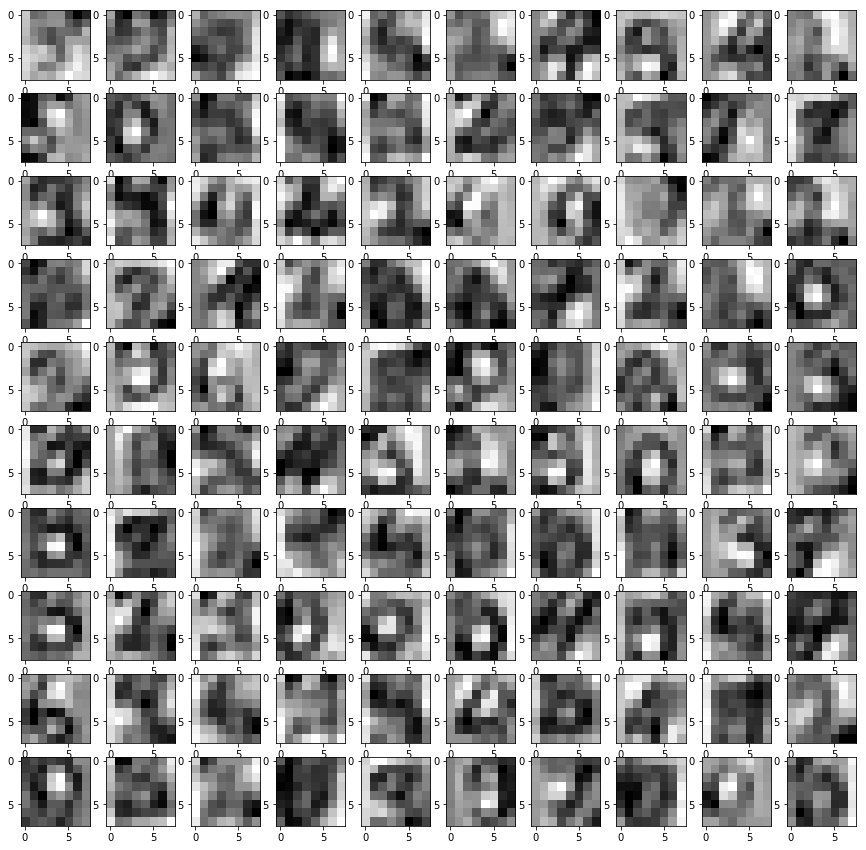

In [39]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')

plt.show()
